# 社交媒体网络技术处理 —— 社交网络评论/博客模块

## 爬虫、数据预处理、词云图模块

在本次的相关技术领域，我们尝试对项目结构进行模块化，用json格式文件进行读取，大致流程如下

先读一下 json

# 0 准备

In [2]:
import json
with open("intro.json","r",encoding="utf-8") as f:
    json_data = json.load(f)
username = json_data['username']
password = json_data['password']
webdriver_path = json_data['chrome_driver_location']
useremail = json_data['useremail']
data_store_location = json_data['data_store_location']
result_analyse_location = json_data['result_analyse_location']
result_picture = json_data['result_picture']
keyword = json_data['keyword']
keyword

'福岛 核'

## 1. 数据爬取

可自行选定社交媒体网站，例如豆瓣，微博，知乎，微信公众号，今日头条等等，

爬取小组选定分析主题相关的社交媒体文本评论数据（要求至少爬取10万条数据，请添加具体实现步骤、运行结果和相关截图）（1分）

我们通过面向对象式写法实现跨模块的调用技术

In [ ]:
from webSpyder.toutiaoSpyder import ToutiaoSpyder
toutiao = ToutiaoSpyder(webdriver_path,keyword)
toutiao.enter_key()
toutiao.getSpyNews()
toutiao.getSpyMicro()
toutiao.store_mongoDB()

# 知乎同理，进行数据获取时用到，爬取相关的评论和文章
from webSpyder.zhihuSpyder import ZhiHuSpyder
zhihu = ZhiHuSpyder(webdriver_path)
zhihu.getComments()
zhihu.getSpyContent()

# 其他模型不再赘述

## 爬取数据预处理

#### 1. 格式文本统一化

我们的数据来源比较复杂，有来着知乎、头条、微博的数据，存储格式也大有不同，
因此我们需要进行所有的数据归一化，同时执行相关的预处理操作

预处理模块的代码参考dataProcessing.py ，包括内部的一系列情况

In [3]:
import pandas as pd
import dataProcessing as dp

excelData = data_store_location+'/excelData'
mongoData = data_store_location+'/mongoData'
otherData = data_store_location+'/otherData'

excel = dp.multi_excel_combine(excelData)
mongo = dp.multi_csv_combine(mongoData)
other = dp.multi_csv_combine(otherData)
print(excel.shape)
print(mongo.shape)
print(other.shape)
print("whole raw data: ",excel.shape[0]+mongo.shape[0]+other.shape[0])

(43843, 12)
(264000, 4)
(55924, 13)
whole raw data:  363767


可以看到未处理原始评论数据集有20w条左右，下面对这些数据进行处理整合

In [4]:
# 集体去重,先处理微博的情况
df_weibo_excel = dp.data_renameweibo(excel)
df_weibo_other = dp.data_renameweibo(other)

# 对excel和other下的微博数据集体抽取并合并起来
dfA = dp.data_cut(df_weibo_excel)
dfB = dp.data_cut(df_weibo_other)
mg = dp.data_cut(mongo)

dfAB = dp.multi_pd_combine(dfA, dfB)
dfABC = dp.multi_pd_combine(dfAB, mg)
dfABC.head(10)

,author,content,time
0,Alexliao-Taiwan,希望你平安@Greenbrothers：现在十分担心福岛核电站的核泄漏，最糟糕的情况核泄漏会...,2011年03月13日 23:38
1,成都商报,#聚焦日本地震#据日本新闻网报道，美国原子能委员会和美国能源部的一个专家小组今(13日)夜启...,2011年03月13日 23:29
2,东山讲坛,#东京~日本~地震~海啸~爆炸#中新网3月13日电 据日本新闻网报道，美国原子能委员会和美国...,2011年03月13日 23:21
3,长江日报,凤凰李淼：福岛核泄漏，日政府最初非常谨慎，公布信息很少，国民一度非常紧张。原子能保安院官员记...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪，说跟设备老化比起来，海啸才是使机械失效引发...,2011年03月13日 23:04
5,完美仙剑217,哎，日本这次，核泄漏，火山爆发，海啸……哎…………可怜的日本…………不知道这次是宫城县和福岛...,2011年03月13日 23:01
6,梓蒙2011,//@凤凰李淼: 福岛3号核电站随时可能爆炸。不过不是核反应堆爆炸，但即使同1号一样，是氢气...,2011年03月13日 22:56
7,梓蒙2011,//@凤凰李淼: 福岛核泄漏，日本政府最初调查非常谨慎，公布的信息很少，国民一度非常紧张。原...,2011年03月13日 22:52
8,微速报,美国原子能委员会和美国能源部专家小组13日晚启程赶赴日本，将协助日本政府处理福岛核电站的核泄...,2011年03月13日 22:50
9,Pug先生,日本核泄漏都慌妈逼啊？还记得1945年美国干了什么吗？美国佬给小日本丢了两颗原子弹！原子弹啊...,2011年03月17日 23:41


pandas中，isnull()是常用的缺失值查看方法：

    df.isnull():查看所有数据是否为缺失值，返回bool值。True：缺失值；False：不是缺失值。
    df.isnull().any():查看每个特征是否存在缺失值，返回bool值。
    df.isnll().sum():返回每个特征中缺失值的具体数量。



In [5]:
dp.show_nan_data(dfABC)

dfABC=dfABC.dropna(axis=0, subset= ['content']).dropna(axis=0,subset=['author'])
dfABC.reset_index(drop=True,inplace=True)#drop=True：删除原行索引；inplace=True:在数据上进行更新

dfABC

author      465
content    1876
time          0
dtype: int64


,author,content,time
0,Alexliao-Taiwan,希望你平安@Greenbrothers：现在十分担心福岛核电站的核泄漏，最糟糕的情况核泄漏会...,2011年03月13日 23:38
1,成都商报,#聚焦日本地震#据日本新闻网报道，美国原子能委员会和美国能源部的一个专家小组今(13日)夜启...,2011年03月13日 23:29
2,东山讲坛,#东京~日本~地震~海啸~爆炸#中新网3月13日电 据日本新闻网报道，美国原子能委员会和美国...,2011年03月13日 23:21
3,长江日报,凤凰李淼：福岛核泄漏，日政府最初非常谨慎，公布信息很少，国民一度非常紧张。原子能保安院官员记...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪，说跟设备老化比起来，海啸才是使机械失效引发...,2011年03月13日 23:04
...,...,...,...
361421,知乎用户,我一个准备去加国留学的看完心里怕怕的 惜命~_~,2017-02-13
361422,L-清源,如果短期旅游有什么影响吗？,2017-02-13
361423,黄sir,这个……事实上答主春节刚从日本旅游回来，还买了些化妆品 〒▽〒 不过仅限于去东京以东。不过大...,2017-02-12
361424,Siqi Xia (作者),天呐 请问哪些地方要注意不能去呢？我还准备四五月份去玩来着 去那玩还能吃海鲜那类吗？现在日本...,2017-02-12


In [6]:
dp.show_nan_data(dfABC)

author     0
content    0
time       0
dtype: int64


In [7]:
dfABC

,author,content,time
0,Alexliao-Taiwan,希望你平安@Greenbrothers：现在十分担心福岛核电站的核泄漏，最糟糕的情况核泄漏会...,2011年03月13日 23:38
1,成都商报,#聚焦日本地震#据日本新闻网报道，美国原子能委员会和美国能源部的一个专家小组今(13日)夜启...,2011年03月13日 23:29
2,东山讲坛,#东京~日本~地震~海啸~爆炸#中新网3月13日电 据日本新闻网报道，美国原子能委员会和美国...,2011年03月13日 23:21
3,长江日报,凤凰李淼：福岛核泄漏，日政府最初非常谨慎，公布信息很少，国民一度非常紧张。原子能保安院官员记...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪，说跟设备老化比起来，海啸才是使机械失效引发...,2011年03月13日 23:04
...,...,...,...
361421,知乎用户,我一个准备去加国留学的看完心里怕怕的 惜命~_~,2017-02-13
361422,L-清源,如果短期旅游有什么影响吗？,2017-02-13
361423,黄sir,这个……事实上答主春节刚从日本旅游回来，还买了些化妆品 〒▽〒 不过仅限于去东京以东。不过大...,2017-02-12
361424,Siqi Xia (作者),天呐 请问哪些地方要注意不能去呢？我还准备四五月份去玩来着 去那玩还能吃海鲜那类吗？现在日本...,2017-02-12


可以看到缺失值已经被处理了，下面我们尝试去除重复值

pandas中，除去重复值的常用方法为drop_duplicate，其基本格式如下：

**DataFrame.drop_duplicates(subset=None, keep='first', inplace=False)：**

关键参数详解：

    subset:用来指定特定的列，默认所有列；
    keep: {'first', 'last', False}。默认值为'first'，用于删除重复项并保留第一次出现的项；
    inplace:是直接在原来数据上修改还是保留一个副本，默认是False

In [8]:
# 测试样例文档
dfN = dfABC.drop_duplicates(['content', 'author'],keep='last')
dfN.reset_index(drop=True,inplace=True)#drop=True：删除原行索引；inplace=True:在数据上进行更新

dfN

,author,content,time
0,Alexliao-Taiwan,希望你平安@Greenbrothers：现在十分担心福岛核电站的核泄漏，最糟糕的情况核泄漏会...,2011年03月13日 23:38
1,成都商报,#聚焦日本地震#据日本新闻网报道，美国原子能委员会和美国能源部的一个专家小组今(13日)夜启...,2011年03月13日 23:29
2,东山讲坛,#东京~日本~地震~海啸~爆炸#中新网3月13日电 据日本新闻网报道，美国原子能委员会和美国...,2011年03月13日 23:21
3,长江日报,凤凰李淼：福岛核泄漏，日政府最初非常谨慎，公布信息很少，国民一度非常紧张。原子能保安院官员记...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪，说跟设备老化比起来，海啸才是使机械失效引发...,2011年03月13日 23:04
...,...,...,...
101088,知乎用户,我一个准备去加国留学的看完心里怕怕的 惜命~_~,2017-02-13
101089,L-清源,如果短期旅游有什么影响吗？,2017-02-13
101090,黄sir,这个……事实上答主春节刚从日本旅游回来，还买了些化妆品 〒▽〒 不过仅限于去东京以东。不过大...,2017-02-12
101091,Siqi Xia (作者),天呐 请问哪些地方要注意不能去呢？我还准备四五月份去玩来着 去那玩还能吃海鲜那类吗？现在日本...,2017-02-12


In [9]:
dfN.loc[dfN['time']=='2017-02-12']

,author,content,time
88321,Jc.L,太生动了 这个举例,2017-02-12
98792,Kimiziduli,有个傻瓜问题...为什么不用钨...钨的熔点不是3000多度，放置在压力容器或者安全壳最下方...,2017-02-12
99275,知乎用户,一篇撕逼好文，小的们，撕起来,2017-02-12
99340,彭子璇,添一句。切尔诺贝利事件时，面对人类第一次重大的核事故，很多苏联人并不清楚切尔诺贝利的危害。所...,2017-02-12
99341,彭子璇,谁知道切尔诺贝利必然对解体起了影响，但是谁都知道苏联本身就是多民族国家。并且是红色阵营的老大...,2017-02-12
...,...,...,...
100705,Newtonny,mark,2017-02-12
100706,克鲁格,真是可怕!,2017-02-12
101090,黄sir,这个……事实上答主春节刚从日本旅游回来，还买了些化妆品 〒▽〒 不过仅限于去东京以东。不过大...,2017-02-12
101091,Siqi Xia (作者),天呐 请问哪些地方要注意不能去呢？我还准备四五月份去玩来着 去那玩还能吃海鲜那类吗？现在日本...,2017-02-12


### 无效符号去除

下面进行去除或替换一些无效或不需要的信息，比如特殊字符、标点符号等。
请注意： 由于可能部分知乎的数据可能比较特殊，如“？？？？”这类的评论，去掉符号以后只有空的值了，因此需要再进行一次预处理，即再去掉横向空值，如果没有就OK

In [10]:
dfN['content'] = dfN['content'].str.replace(r'[^\w]+', '')
dfN.head()

<ipython-input-10-193a5cac010d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfN['content'] = dfN['content'].str.replace(r'[^\w]+', '')


,author,content,time
0,Alexliao-Taiwan,希望你平安Greenbrothers现在十分担心福岛核电站的核泄漏最糟糕的情况核泄漏会波及到...,2011年03月13日 23:38
1,成都商报,聚焦日本地震据日本新闻网报道美国原子能委员会和美国能源部的一个专家小组今13日夜启程赶来日本...,2011年03月13日 23:29
2,东山讲坛,东京日本地震海啸爆炸中新网3月13日电据日本新闻网报道美国原子能委员会和美国能源部的一个专家...,2011年03月13日 23:21
3,长江日报,凤凰李淼福岛核泄漏日政府最初非常谨慎公布信息很少国民一度非常紧张原子能保安院官员记者会也都是...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011年03月13日 23:04


In [11]:
number = 0
for i in dfN['content'].values:
    if i == '':
        number+=1
print(number)

174


可以发现有这些数据content删除之后变成没有内容的假空值（但不是真空值 **"" != None**），但这类没有意义，也不适合作为重复值舍去

接下来我们对这类异常值进行预处理，直接把这一行的数据丢掉

In [12]:
import numpy as np
dfN['content'].replace("",np.nan,inplace=True)
dfN=dfN.dropna(axis=0, subset= ['content']).dropna(axis=0,subset=['author'])
dfN.reset_index(drop=True,inplace=True) #drop=True：删除原行索引；inplace=True:在数据上进行更新
dfN

F:\Anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,author,content,time
0,Alexliao-Taiwan,希望你平安Greenbrothers现在十分担心福岛核电站的核泄漏最糟糕的情况核泄漏会波及到...,2011年03月13日 23:38
1,成都商报,聚焦日本地震据日本新闻网报道美国原子能委员会和美国能源部的一个专家小组今13日夜启程赶来日本...,2011年03月13日 23:29
2,东山讲坛,东京日本地震海啸爆炸中新网3月13日电据日本新闻网报道美国原子能委员会和美国能源部的一个专家...,2011年03月13日 23:21
3,长江日报,凤凰李淼福岛核泄漏日政府最初非常谨慎公布信息很少国民一度非常紧张原子能保安院官员记者会也都是...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011年03月13日 23:04
...,...,...,...
100914,知乎用户,我一个准备去加国留学的看完心里怕怕的惜命_,2017-02-13
100915,L-清源,如果短期旅游有什么影响吗,2017-02-13
100916,黄sir,这个事实上答主春节刚从日本旅游回来还买了些化妆品不过仅限于去东京以东不过大家不知道注意过没日...,2017-02-12
100917,Siqi Xia (作者),天呐请问哪些地方要注意不能去呢我还准备四五月份去玩来着去那玩还能吃海鲜那类吗现在日本零食已经...,2017-02-12


In [13]:
# 存储数据

import filestore as fs
a = fs.FileStore(dfN, 'processed-content-data')
a.download_as_csv()

OK


### 中文分词技术



In [14]:
import wordCleaner
wdc = wordCleaner.WordCleaner(dfN)
wdc.stop_words_data('results/random-nuclear/Res-Dat/')

wdc.jieba_cut('results/random-nuclear/Res-Dat/')


Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\admin\AppData\Local\Temp\jieba.cache
Loading model cost 0.994 seconds.
Prefix dict has been built successfully.


KeyboardInterrupt: 

**去重复词设计**

**词云图设计**


{'日本': 1.0, '福岛': 0.7193395320397253, '核电站': 0.37325197783857933, '废水': 0.2840784104554391, '污水': 0.2146291226557384, '视频': 0.20468903288413393, '全文': 0.16636089433756587, '中国': 0.1486258156677644, '链接': 0.12668544858567382, '网页': 0.1219874866789901, '东京': 0.11046625906266468, '核污染': 0.1082104084700819, '美国': 0.10397652216013517, '核泄漏': 0.10012296917632094, '太平洋': 0.09338426326773416, '核辐射': 0.09103848593516867, '事故': 0.08845339580324901, '海洋': 0.0880745585171814, '地震': 0.08677963500536756, '环境': 0.0829352724736272, '核事故': 0.08177572547485508, '问题': 0.08007174755977982, '国家': 0.07232328815290415, '入海': 0.06950391613421061, '电力公司': 0.06080322206923868, '人类': 0.060195934092116314, '放射性': 0.06006093443405548, '时差': 0.06001916591541537, '大海': 0.05987494702148295, '韩国': 0.056761259918636835, '专家': 0.0545106604447986, '世界': 0.054231740429410175, '政府': 0.048147580477495656, '核电': 0.0461002600087303, '新闻': 0.04540999962266498, '全球': 0.045058212822845015, '大臣': 0.045016284132531545, '食品': 0.043

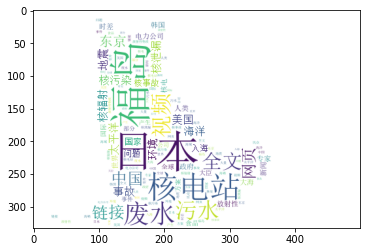

In [15]:
from dataVision import DataVisitor
import jieba
import jieba.analyse
vis = DataVisitor(dfN)
vis.show_word_cloud('material/simsun.ttc', 'material/cat.jpg','results/random-nuclear/word_frequency.txt', 'results/random-nuclear/cat_cloud.png')

In [1]:
import pandas as pd
dfN = pd.read_csv(r"results/random-nuclear/Res-Dat/processed-content-data.csv")
dfN.shape
# dfN.head(10)

(100919, 4)

## 聚类搭建模型

### 1.轮廓系数模型导入

In [6]:
import dataCluster

clstr = dataCluster.DataCluster(dfN, 'nuclear-comment')
clstr.generate_wordcountvector()
clstr

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\admin\AppData\Local\Temp\jieba.cache
Loading model cost 0.663 seconds.
Prefix dict has been built successfully.
F:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'a', 'ain', 'aren', 'c', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'i', 'isn', 'll', 'm', 'mon', 's', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn', '下', '不', '为什', '什', '今', '使', '先', '却', '只', '唷', '啪', '喔', '天', '好', '後', '最', '漫', '然', '特', '特别', '见', '设', '说', '达', '面', '麽', '－'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


MemoryError: Unable to allocate 93.7 GiB for an array with shape (100919, 124612) and data type int64